In [64]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import SGD
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
dataset=datasets.MNIST(root="./data", train=True,transform=transforms.ToTensor(), download=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 170kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.76MB/s]


In [6]:
dataset.__len__()
image,label=dataset[6]
image.shape

torch.Size([1, 28, 28])

In [7]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

In [42]:
class Gen(nn.Module):
    def __init__(self):
        super(Gen, self).__init__()

        self.generator =  nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32, 1*28*28)
        )

    def forward(self, x):
        x = self.generator(x)
        return x

In [43]:
class Dis(nn.Module):
    def __init__(self):
        super(Dis, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(1*28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.discriminator(x)
        return x

In [44]:
gen=Gen()
dis=Dis()

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer_gen = SGD(gen.parameters(), lr=0.001, momentum=0.9)
optimizer_dis = SGD(dis.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen.to(device)
dis.to(device)

Dis(
  (discriminator): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
    (5): Sigmoid()
  )
)

In [60]:
z = torch.empty(16,16).uniform_(-1, 1).to(device)
output=dis(gen(z))
output.shape
# pic=output.view(16, 1, 28, 28)[0].cpu()
# pic = np.transpose(pic.detach().numpy(), (1, 2, 0))
# plt.imshow(pic)
# plt.show()



torch.Size([16, 2])

In [93]:
def train(epoch):
    total_dis_loss = []
    total_gen_loss = []
    for i in tqdm(range(epoch)):
        epoch_dis_loss = 0
        epoch_gen_loss = 0

        for batch_idx, (inputs, _) in enumerate(data_loader):
            inputs = inputs.to(device)
            optimizer_gen.zero_grad()
            optimizer_dis.zero_grad()
            z = torch.empty(16,16).uniform_(-1, 1).to(device)

            gen.eval()
            dis.train()
            pic = gen(z)
            output=dis(pic)
            # print(pic.shape)
            # print(inputs.shape)
            # dis(inputs)
            loss_dis = criterion(output,torch.zeros(16).long().to(device))+criterion(dis(inputs.view(16,784)),torch.ones(16).long().to(device))
            loss_dis.backward(retain_graph=True)
            optimizer_dis.step()
            
            dis.eval()
            gen.train()
            loss_gen = criterion(dis(pic),torch.zeros(16).long().to(device))
            loss_gen.backward()
            optimizer_gen.step()


            epoch_dis_loss += loss_dis.item()
            epoch_gen_loss += loss_gen.item()

        total_dis_loss.append(epoch_dis_loss)
        total_gen_loss.append(epoch_gen_loss)

        avg_dis_loss = epoch_dis_loss / len(data_loader)
        avg_gen_loss = epoch_gen_loss / len(data_loader)
        print(f"Epoch:{i}: Avg_Dis_Loss:{avg_dis_loss}\tAvg_Gen_Loss:{avg_gen_loss}")


In [94]:
train(10)

 10%|█         | 1/10 [00:52<07:54, 52.68s/it]

Epoch:0: Avg_Dis_Loss:0.7161501229127248	Avg_Gen_Loss:0.3643086191733678


 20%|██        | 2/10 [01:43<06:53, 51.66s/it]

Epoch:1: Avg_Dis_Loss:0.6270994470755259	Avg_Gen_Loss:0.3134431921005249


 30%|███       | 3/10 [02:33<05:56, 50.96s/it]

Epoch:2: Avg_Dis_Loss:0.6268102531592051	Avg_Gen_Loss:0.31334409006436664


 40%|████      | 4/10 [03:24<05:04, 50.80s/it]

Epoch:3: Avg_Dis_Loss:0.6267115006446838	Avg_Gen_Loss:0.31331324889659884


 50%|█████     | 5/10 [04:14<04:13, 50.60s/it]

Epoch:4: Avg_Dis_Loss:0.6266623365720113	Avg_Gen_Loss:0.3132988071680069


 60%|██████    | 6/10 [05:04<03:21, 50.49s/it]

Epoch:5: Avg_Dis_Loss:0.6266327055295309	Avg_Gen_Loss:0.3132901413679123


 70%|███████   | 7/10 [05:55<02:31, 50.59s/it]

Epoch:6: Avg_Dis_Loss:0.6266132087866465	Avg_Gen_Loss:0.3132846513271332


 80%|████████  | 8/10 [06:41<01:38, 49.03s/it]

Epoch:7: Avg_Dis_Loss:0.6265993985017141	Avg_Gen_Loss:0.31328082688649495


 90%|█████████ | 9/10 [07:23<00:46, 46.95s/it]

Epoch:8: Avg_Dis_Loss:0.6265891799767812	Avg_Gen_Loss:0.31327807439963024


100%|██████████| 10/10 [08:09<00:00, 48.97s/it]

Epoch:9: Avg_Dis_Loss:0.626581254196167	Avg_Gen_Loss:0.31327593733469644


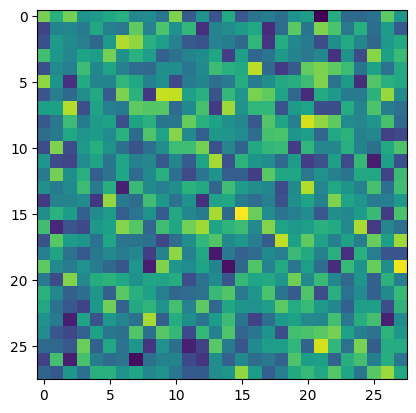

In [99]:
z = torch.empty(16).uniform_(-1, 1).to(device)
output=gen(z)
pic=output.view(1, 28, 28).cpu()
pic = np.transpose(pic.detach().numpy(), (1, 2, 0))
plt.imshow(pic)
plt.show()